<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pulsos" data-toc-modified-id="Pulsos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pulsos</a></span><ul class="toc-item"><li><span><a href="#Pulso-Gaussiano" data-toc-modified-id="Pulso-Gaussiano-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pulso Gaussiano</a></span></li><li><span><a href="#Pulso-super-Gaussiano" data-toc-modified-id="Pulso-super-Gaussiano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pulso super Gaussiano</a></span></li></ul></li><li><span><a href="#Equação-básica-de-propagação" data-toc-modified-id="Equação-básica-de-propagação-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Equação básica de propagação</a></span><ul class="toc-item"><li><span><a href="#Pulso-Gaussiano-&quot;chirpado&quot;----chirped-Gaussian-pulse" data-toc-modified-id="Pulso-Gaussiano-&quot;chirpado&quot;----chirped-Gaussian-pulse-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Pulso Gaussiano "chirpado"  - <em>chirped Gaussian pulse</em></a></span></li><li><span><a href="#Transmissão-10G-OOK-apenas-com-dispersão" data-toc-modified-id="Transmissão-10G-OOK-apenas-com-dispersão-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Transmissão 10G OOK apenas com dispersão</a></span></li></ul></li></ul></div>

In [1]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import numpy as np
import scipy.special as sp
from  scipy.constants import c
import matplotlib.pyplot as plt
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR
from commpy.utilities  import signal_power, upsample
from utils.models import mzm

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Pulsos

## Pulso Gaussiano

Como exemplo de aplicação, considere que o pulso tem formato Gaussiano:
\begin{equation}
A\left( 0,t \right) = A_0e^{-\frac{1}{2}\left( \frac{t}{T_0} \right)^2},
\end{equation}
em que $A_0$ é a amplitude de pico e $T_0$ a metade da largura de $1/e$ do ponto de intensidade (ou 1,665$T_0$ largura à meia altura - FWHM - *full width at half maximum*). A transformada de Fourier do pulso é
\begin{equation}
\widetilde{A} \left( 0, \omega \right) = A_0 T_0 \sqrt{2 \pi} e^{\left[-\frac{1}{2}\left( w T_0 \right)^2\right]}
\end{equation}

In [4]:
def GaussPulse(a0, t0, t):      # Expressão do pulso Gaussiano
  return a0*np.exp(-0.5*(t/t0)**2)
def FGaussPulse(a0, t0, freq):  # Transformada de Fourier do pulso Gaussiano (analítica)
  return a0*t0*np.sqrt(2*np.pi)*np.exp(-0.5*(2*np.pi*freq*t0)**2)

In [5]:
T0 = np.array([0.2, 0.1, 0.05]) # Parâmetro meia largura @1/e
A0 = 1                          # Amplitude do pulso
fs = 100                        # Taxa de amostragem
NFFT = 1024                     # Número de pontos da transformada
t  = np.arange(-0.5,0.5,1/fs)   # Duração da janela do pulso
f = fs/NFFT * np.arange(-NFFT/2,NFFT/2)
L = len(t)                      # Comprimento da janela temporal

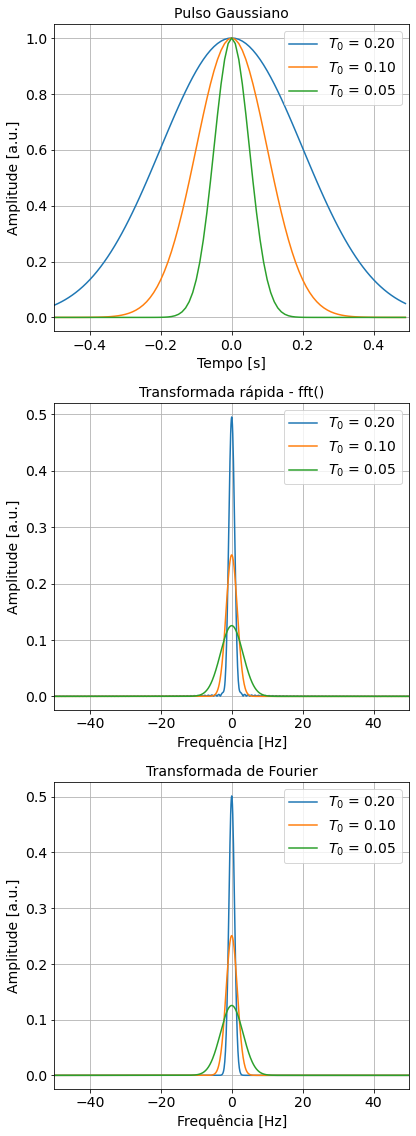

In [6]:
fig, axs = plt.subplots(3,1, figsize=(6,16))
for i in range(len(T0)):
  x   = GaussPulse(A0, T0[i], t)             # Pulso Gaussiano  
  axs[0].plot(t, x, label = r'$T_0$ = %3.2f' % (T0[i]))
  axs[0].set_xlabel('Tempo [s]')
  axs[0].set_ylabel('Amplitude [a.u.]')    
  Xf  = np.fft.fftshift(np.fft.fft(x, NFFT)) # Transformada de Fourier do pulso (fft)
  axs[1].plot(f, abs(Xf)/L, label = r'$T_0$ = %3.2f' % (T0[i]))
  axs[1].set_xlabel('Frequência [Hz]')
  axs[1].set_ylabel('Amplitude [a.u.]')
  Xa  = FGaussPulse(A0, T0[i], f)            # Trasnformada de Fourier do pulso (analítica)
  axs[2].plot(f, Xa, label = r'$T_0$ = %3.2f' % (T0[i]))
  axs[2].set_xlabel('Frequência [Hz]')
  axs[2].set_ylabel('Amplitude [a.u.]')

axs[0].set_xlim([-0.5,0.5])
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Pulso Gaussiano')

axs[1].set_xlim([-fs/2,fs/2])
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Transformada rápida - fft()')

axs[2].set_xlim([-fs/2,fs/2])
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Transformada de Fourier')
plt.tight_layout()

## Pulso super Gaussiano

Há outros formatos de pulsos, como exemplo, o pulso super Gaussiano:
\begin{equation}
    A\left( 0,t \right) = A_0 e^{-\frac{1}{2}\left( \frac{t}{T_0} \right)^{2m}},
\end{equation}
em que $m$ corresponde ao coeficiente de formato de borda. Para $m = 1$, é obtido o pulso Gaussiano descrito anteriormente. Para elevados valores de $m$ o pulso apresenta formato próximo ao retangular.

In [7]:
def SuperGaussPulse(a0, t0, t, m):      # Expressão do pulso super Gaussiano
  return a0*np.exp(-0.5*(t/t0)**(2*m))

In [8]:
T0 = 0.1
m  = np.array([1, 2, 10, 100])

Text(0.5, 1.0, 'Transformada rápida - fft()')

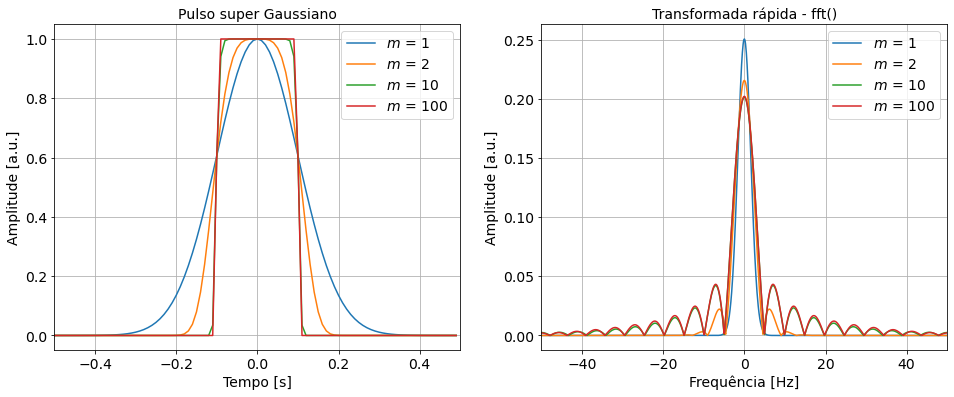

In [9]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
for i in range(len(m)):
  x   = SuperGaussPulse(A0, T0, t, m[i])        # Pulso super Gaussiano  
  axs[0].plot(t, x, label = r'$m$ = %d' % (m[i]))
  axs[0].set_xlabel('Tempo [s]')
  axs[0].set_ylabel('Amplitude [a.u.]')
  Xf  = np.fft.fftshift(np.fft.fft(x, NFFT)) # Transformada de Fourier do pulso (fft)
  axs[1].plot(f, abs(Xf)/L, label = r'$m$ = %d' % (m[i]))
  axs[1].set_xlabel('Frequência [Hz]')
  axs[1].set_ylabel('Amplitude [a.u.]')

axs[0].set_xlim([-0.5,0.5])
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Pulso super Gaussiano')

axs[1].set_xlim([-fs/2,fs/2])
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Transformada rápida - fft()')

# Equação básica de propagação

A equação básica de propagação, desconsiderando perdas e efeitos não lineares, é:
\begin{equation}
\frac{\partial A}{\partial z} + i \frac{\beta_2}{2}\frac{\partial^2 A}{\partial t^2} - \frac{\beta_3}{6}\frac{\partial^3 A}{\partial t^3} = 0.
\end{equation}
Podemos deconsiderar ainda, o termo de terceira ordem da expansão da constante de propagação:
\begin{equation}
\frac{\partial A}{\partial z} + i \frac{\beta_2}{2}\frac{\partial^2 A}{\partial t^2} = 0.
\end{equation}
A solução desta equação é obtida a partir do método da transformada de Fourier:
\begin{equation}
\widetilde{A}\left(z, \omega \right) = \widetilde{A}\left(0, \omega \right) e^{j\frac{\beta_2}{2} \omega^2 z},
\end{equation}
em que $\widetilde{A}\left(0, \omega \right)$ é a transformada de Fourier do campo incidente em $z = 0$:
\begin{equation}
\widetilde{A}\left(0, \omega \right) = \int_{-\infty}^{\infty}A\left(0, t\right)e^{i \omega t} \text{d}t.
\end{equation}


In [33]:
fs = 256                        # Taxa de amostragem
NFFT = 256                      # Número de pontos da transformada
t  = np.arange(-0.5,0.5,1/fs)   # Duração da janela do pulso
L = len(t)                      # Comprimento da janela temporal
f = fs/NFFT * np.arange(-NFFT/2,NFFT/2)
beta2 = 20e-6                   # parâmetro GVD
z = 250                         # distância de propagação
T0 = 0.05                       # Parâmetro meia largura @1/e
A0 = 1                          # Amplitude do pulso

Função de transferência do canal:

In [34]:
H  = np.exp(1j*0.5*beta2*z*(2*np.pi*f)**2) # Função de transferência do canal

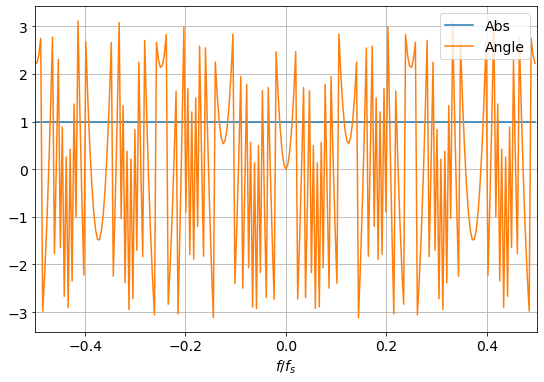

In [35]:
fig = plt.figure(figsize=(9,6))
#plt.plot(f/fs, H.real, f/fs, H.imag)
plt.plot(f/fs, abs(H), f/fs, np.angle(H))
plt.xlabel(r'$f/f_s$')
plt.xlim([-0.5,0.5])
#plt.legend(['Real', 'Imag'], loc = 'upper right')
plt.legend(['Abs', 'Angle'], loc = 'upper right')
plt.grid(True)

O pulso gerado será aplicado ao canal:

In [36]:
# Domínio T
x  = GaussPulse(A0, T0, t)       # Pulso Gaussiano
# Domínio F
X  = FGaussPulse(A0, T0, f)      # Transformada de Fourier do pulso Gaussiano (analítica)
XH = X*H                         # Sinal resultante
# Domínio T
xh  = np.fft.ifftshift(np.fft.ifft(XH)) # Transformada inversa (ifft)
xhA = T0/np.sqrt(T0**2-1j*beta2*z) * np.exp(-(t**2)/(2*(T0**2-1j*beta2*z))) # Sinal resultante (expressão analítica)

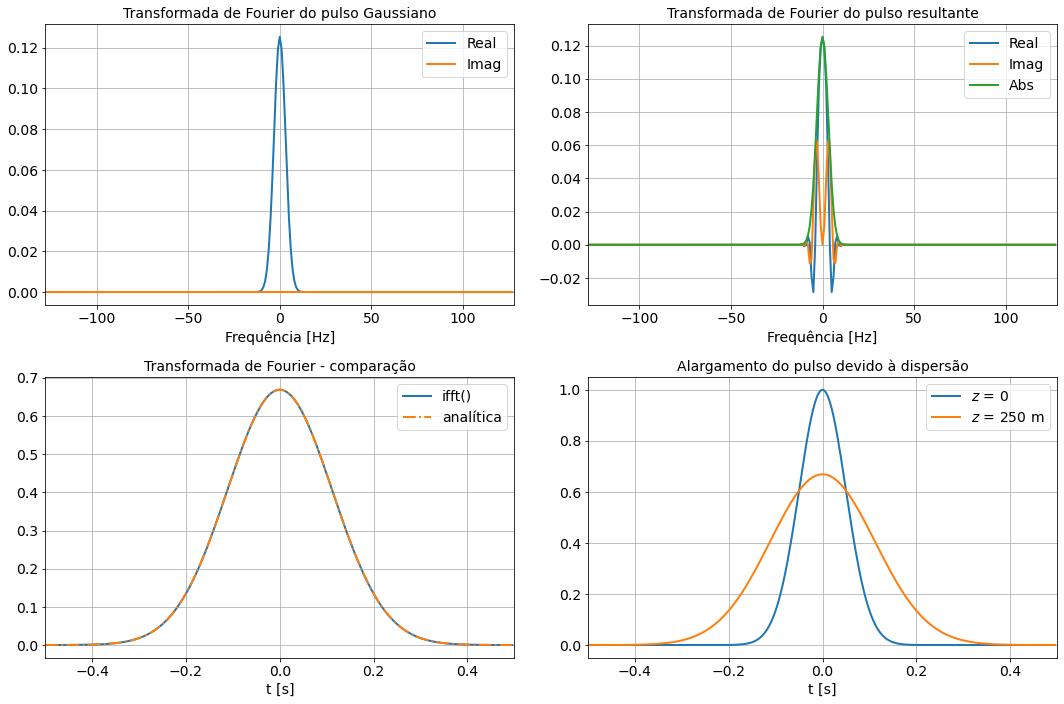

In [37]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(f, X.real, label = 'Real', linewidth = 2)
axs[0,0].plot(f, X.imag, label = 'Imag', linewidth = 2)
axs[0,0].set_xlabel('Frequência [Hz]')
axs[0,0].set_xlim([-fs/2,fs/2])
axs[0,0].set_title('Transformada de Fourier do pulso Gaussiano')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].plot(f, XH.real, label = 'Real', linewidth = 2)
axs[0,1].plot(f, XH.imag, label = 'Imag', linewidth = 2)
axs[0,1].plot(f, np.abs(XH), label = 'Abs', linewidth = 2)
axs[0,1].set_xlabel('Frequência [Hz]')
axs[0,1].set_xlim([-fs/2,fs/2])
axs[0,1].set_title('Transformada de Fourier do pulso resultante')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].plot(t, np.abs(xh*L), label = 'ifft()', linewidth = 2)
axs[1,0].plot(t, np.abs(xhA), '-.', label = 'analítica', linewidth = 2)
axs[1,0].set_xlabel('t [s]')
axs[1,0].set_xlim([-0.5,0.5])
axs[1,0].set_title('Transformada de Fourier - comparação')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].plot(t, x, label = r'$z$ = 0', linewidth = 2)
axs[1,1].plot(t, np.abs(xhA), label = r'$z$ = %d m' %(z), linewidth = 2)
axs[1,1].set_xlabel('t [s]')
axs[1,1].set_xlim([-0.5,0.5])
axs[1,1].set_title('Alargamento do pulso devido à dispersão')
axs[1,1].grid(True)
axs[1,1].legend()

plt.tight_layout()

O fator de alargamento do pulso é determinado por
\begin{equation}
\frac{T_1(z)}{T_0} = \sqrt{1 + \left(\frac{z}{L_D}\right)^2}
\end{equation}
em que $L_D = T_0^2 / \left|\beta_2\right|$ é o comprimento de dispersão. Nesse comprimento, o pulso Gaussiano é mais $\sqrt{2}$ mais largo que o original.

In [46]:
LD = (T0**2)/abs(beta2)
print('Comprimento de dispersão [m]: %f' %(LD))

Comprimento de dispersão [m]: 125.000000


In [56]:
T1 = T0*np.sqrt(1+(z/LD)**2)
print("Largura do pulso após %f [m]: %f [s]" %(z, T1))
print("Fator de alargamento: %f" %(T1/T0))

Largura do pulso após 250.000000 [m]: 0.111803 [s]
Fator de alargamento: 2.236068


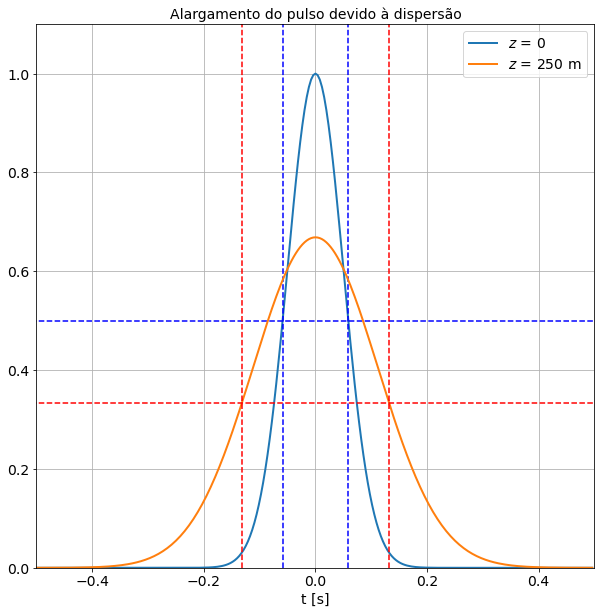

In [61]:
fig = plt.figure(figsize=(10,10))

plt.plot(t, x, label = r'$z$ = 0', linewidth = 2)
plt.plot([-1,1],[0.5,0.5], 'b--')
plt.plot([1.665*T0/np.sqrt(2),1.665*T0/np.sqrt(2)],[0,1.2], 'b--')
plt.plot([-1.665*T0/np.sqrt(2),-1.665*T0/np.sqrt(2)],[0,1.2], 'b--')

plt.plot(t, np.abs(xhA), label = r'$z$ = %d m' %(z), linewidth = 2)
maxxhA = max(np.abs(xhA))
plt.plot([-1,1],[0.5*maxxhA,0.5*maxxhA], 'r--')
plt.plot([1.665*T1/np.sqrt(2),1.665*T1/np.sqrt(2)],[0,1.2], 'r--')
plt.plot([-1.665*T1/np.sqrt(2),-1.665*T1/np.sqrt(2)],[0,1.2], 'r--')

plt.xlabel('t [s]')
plt.xlim([-0.5,0.5])
plt.ylim([0,1.1])
plt.title('Alargamento do pulso devido à dispersão')
plt.grid(True)
plt.legend()

## Pulso Gaussiano "chirpado"  - *chirped Gaussian pulse*

Quando a frequência da portadora varia com o tempo em um pulso gaussiano, dizemos que o pulso apresenta *chirp*. A amplitude desse sinal é
\begin{equation}
A\left( 0,t \right) = A_0e^{-\frac{\left(1+iC\right)}{2}\left( \frac{t}{T_0} \right)^2},
\end{equation}
em que $C$ é o parâmetro que quantifica a variação de frequência do pulso relacionado com a variação de fase $\phi(t)$ por
\begin{equation}
  \delta\omega(t) = -\frac{\partial \phi}{\partial t} = \frac{C}{T_0^2}t.
\end{equation}
A variação de fase $\delta\omega(t)$ é denominada de *chirp*. A transformada de Fourier do pulso gaussiano com *chirp* é
\begin{equation}
\widetilde{A}\left(0, \omega \right) = A_0\sqrt{\left( \frac{2\pi T_0^2}{1+iC} \right)} e^{-\frac{1}{2}\left[\frac{\left( \omega T_0\right)^2}{1+iC}\right]},
\end{equation}

Definição das expressões dos pulsos com "gorjeio":

In [40]:
def CGaussPulse(a0, t0, t, c):      # Expressão do pulso Gaussiano
  return a0*np.exp(-0.5*(1+1j*c)*(t/t0)**2)
def CFGaussPulse(a0, t0, freq, c):  # Transformada de Fourier do pulso Gaussiano (analítica)
  return a0*np.sqrt((2*np.pi*t0**2)/(1+1j*C))*np.exp(-0.5*((2*np.pi*freq*t0)**2)/(1+1j*C))

In [41]:
T0 = np.array([0.2, 0.1, 0.05]) # Parâmetro meia largura @1/e
A0 = 1                          # Amplitude do pulso
fs = 100                        # Taxa de amostragem
NFFT = 1024                     # Número de pontos da transformada
t  = np.arange(-0.5,0.5,1/fs)   # Duração da janela do pulso
L = len(t)                      # Comprimento da janela temporal
f = fs/NFFT * np.arange(-NFFT/2,NFFT/2)
C = 2

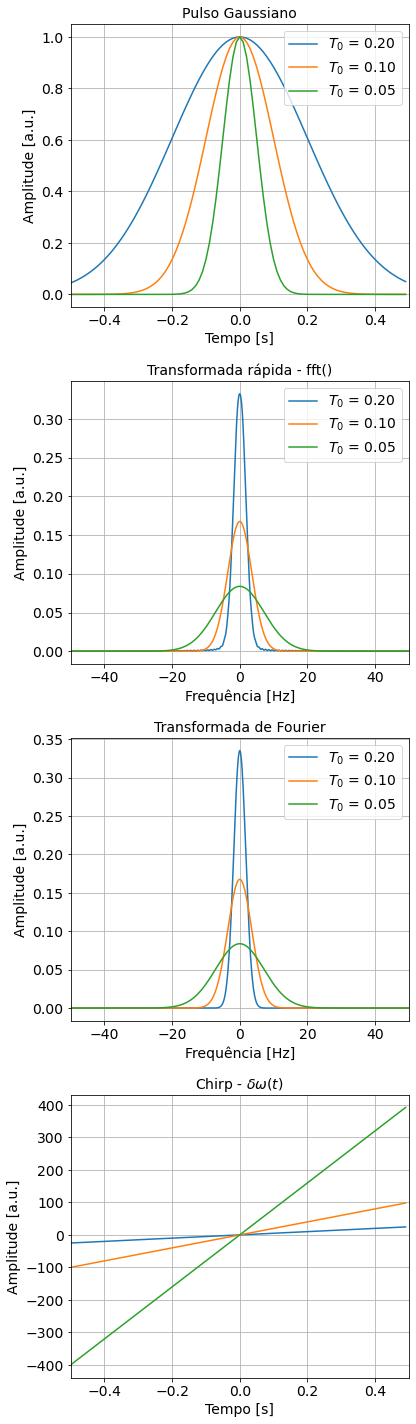

In [42]:
fig, axs = plt.subplots(4,1, figsize=(6,20))
for i in range(len(T0)):
  x   = CGaussPulse(A0, T0[i], t, C)         # Pulso Gaussiano  
  axs[0].plot(t, abs(x), label = r'$T_0$ = %3.2f' % (T0[i]))
  axs[0].set_xlabel('Tempo [s]')
  axs[0].set_ylabel('Amplitude [a.u.]')
  Xf  = np.fft.fftshift(np.fft.fft(x, NFFT)) # Transformada de Fourier do pulso (fft)
  axs[1].plot(f, abs(Xf)/L, label = r'$T_0$ = %3.2f' % (T0[i]))
  axs[1].set_xlabel('Frequência [Hz]')
  axs[1].set_ylabel('Amplitude [a.u.]')
  Xa  = CFGaussPulse(A0, T0[i], f, C)        # Trasnformada de Fourier do pulso (analítica)
  axs[2].plot(f, abs(Xa), label = r'$T_0$ = %3.2f' % (T0[i]))
  axs[2].set_xlabel('Frequência [Hz]')
  axs[2].set_ylabel('Amplitude [a.u.]')
  dOmega = t*C/(T0[i]**2)
  axs[3].plot(t, dOmega)
  axs[3].set_xlabel('Tempo [s]')
  axs[3].set_ylabel('Amplitude [a.u.]')

axs[0].set_xlim([-0.5,0.5])
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Pulso Gaussiano')

axs[1].set_xlim([-fs/2,fs/2])
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Transformada rápida - fft()')

axs[2].set_xlim([-fs/2,fs/2])
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Transformada de Fourier')
plt.tight_layout()

axs[3].set_xlim([-0.5,0.5])
axs[3].grid(True)
axs[3].set_title('Chirp - $\delta \omega(t)$')

plt.tight_layout()

Considerando o canal dispersivo com parâmetro GVD $\beta_2$, o pulso resultante é
\begin{equation}
A\left( z, t\right) = \frac{A_0}{\sqrt{Q(z)}}e^{-\frac{1}{2}\left[\frac{\left( 1+iC \right)}{Q(z)} \left(\frac{t}{T_0}\right)^2\right]},
\end{equation}
em que $Q(z) = 1+(C-i)\beta_2 z/T_0^2$. O pulso é mantido Gaussiano, entretanto, com largura, amplitude e *chirp* alterados.

In [43]:
T0 = 0.05                       # Parâmetro meia largura @1/e
A0 = 1                          # Amplitude do pulso
fs = 256                        # Taxa de amostragem
NFFT = 256                      # Número de pontos da transformada
beta2 = 20e-6                   # parâmetro GVD
z = 250                         # distância de propagação
t  = np.arange(-0.5,0.5,1/fs)   # Duração da janela do pulso
L = len(t)                      # Comprimento da janela temporal
f = fs/NFFT * np.arange(-NFFT/2,NFFT/2)

Função de transferência do canal:

In [44]:
H  = np.exp(1j*0.5*beta2*z*(2*np.pi*f)**2) # Função de transferência do canal

O pulso gerado será aplicado ao canal:

In [45]:
# Domínio T
xC  = CGaussPulse(A0, T0, t, C)       # Pulso Gaussiano
# Domínio F
XC  = CFGaussPulse(A0, T0, f, C)      # Transformada de Fourier do pulso Gaussiano (analítica)
XHC = XC*H                             # Sinal resultante
# Domínio T
xhC  = np.fft.ifftshift(np.fft.ifft(XHC)) # Transformada inversa (ifft)
Q = 1 + (C-1j)*beta2*z/T0**2  
xhAC = A0/np.sqrt(Q) * np.exp(-0.5*((1+1j*C)/Q)*(t/T0)**2) # Sinal resultante (expressão analítica)

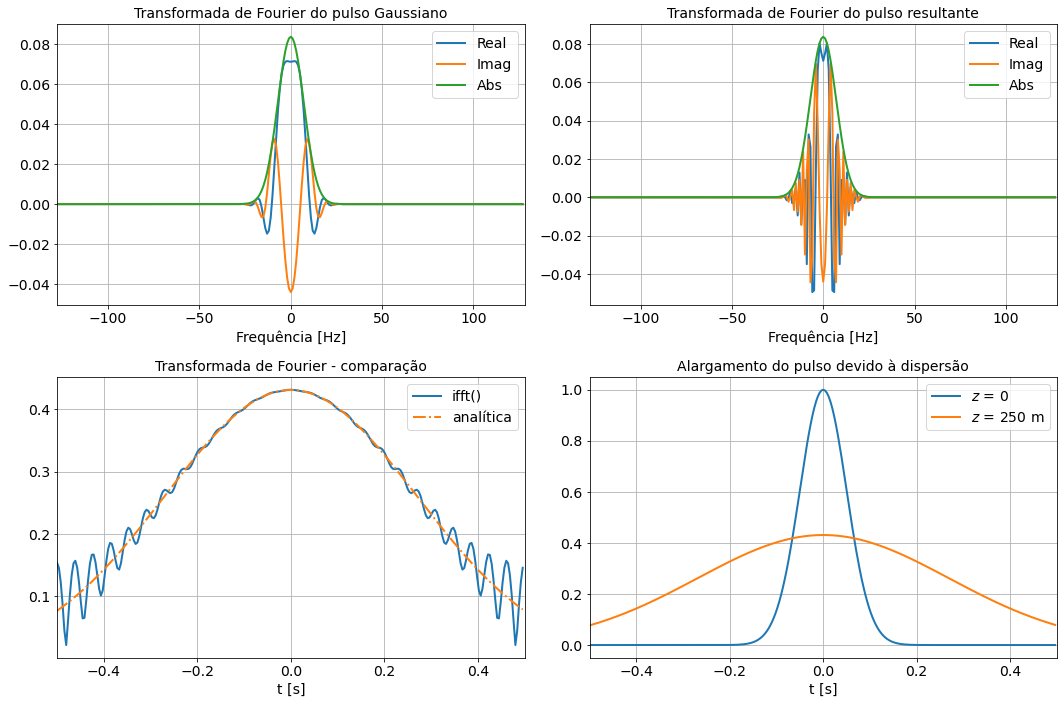

In [47]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(f, XC.real, label = 'Real', linewidth = 2)
axs[0,0].plot(f, XC.imag, label = 'Imag', linewidth = 2)
axs[0,0].plot(f, abs(XC), label = 'Abs', linewidth = 2)
axs[0,0].set_xlabel('Frequência [Hz]')
axs[0,0].set_xlim([-fs/2,fs/2])
axs[0,0].set_title('Transformada de Fourier do pulso Gaussiano')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].plot(f, XHC.real, label = 'Real', linewidth = 2)
axs[0,1].plot(f, XHC.imag, label = 'Imag', linewidth = 2)
axs[0,1].plot(f, np.abs(XHC), label = 'Abs', linewidth = 2)
axs[0,1].set_xlabel('Frequência [Hz]')
axs[0,1].set_xlim([-fs/2,fs/2])
axs[0,1].set_title('Transformada de Fourier do pulso resultante')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].plot(t, abs(xhC*L), label = 'ifft()', linewidth = 2)
axs[1,0].plot(t, abs(xhAC), '-.', label = 'analítica', linewidth = 2)
axs[1,0].set_xlabel('t [s]')
axs[1,0].set_xlim([-0.5,0.5])
axs[1,0].set_title('Transformada de Fourier - comparação')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].plot(t, abs(xC), label = r'$z$ = 0', linewidth = 2)
axs[1,1].plot(t, abs(xhAC), label = r'$z$ = %d m' %(z), linewidth = 2)
axs[1,1].set_xlabel('t [s]')
axs[1,1].set_xlim([-0.5,0.5])
axs[1,1].set_title('Alargamento do pulso devido à dispersão')
axs[1,1].grid(True)
axs[1,1].legend()

plt.tight_layout()

O fator de alargamento do pulso neste caso com gorjeio é determinado por
\begin{equation}
\frac{T_1(z)}{T_0} = \sqrt{\left(1 + \frac{C\beta_2 z}{T_0^2}\right)^2 + \left(\frac{z}{L_D}\right)^2}
\end{equation}
em que $C$ \'e o coeficiente de gorjeio.

In [50]:
LD = (T0**2)/abs(beta2)
print('Comprimento de dispersão [m]: %f' %(LD))

Comprimento de dispersão [m]: 125.000000


In [51]:
T1 = T0*np.sqrt((1+C*beta2*z/(T0**2))**2 + (z/LD)**2)
print("Largura do pulso após %f [m]: %f [s]" %(z, T1))
print("Fator de alargamento: %f" %(T1/T0))

Largura do pulso após 250.000000 [m]: 0.269258 [s]
Fator de alargamento: 5.385165


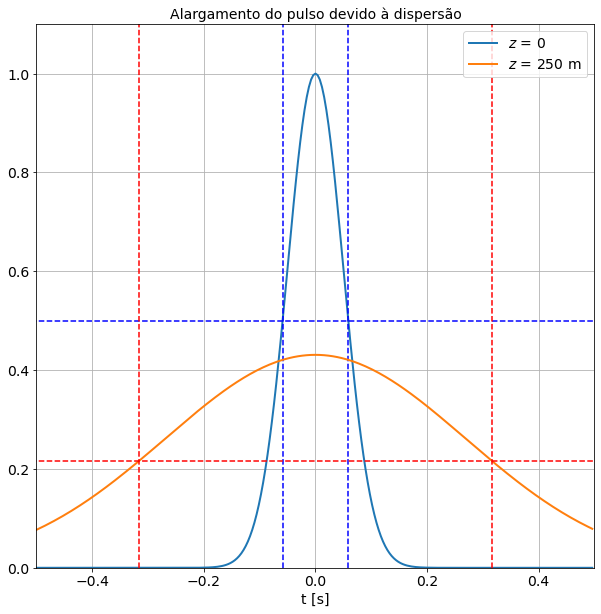

In [52]:
fig = plt.figure(figsize=(10,10))

plt.plot(t, abs(xC), label = r'$z$ = 0', linewidth = 2)
plt.plot([-1,1],[0.5,0.5], 'b--')
plt.plot([1.665*T0/np.sqrt(2),1.665*T0/np.sqrt(2)],[0,1.2], 'b--')
plt.plot([-1.665*T0/np.sqrt(2),-1.665*T0/np.sqrt(2)],[0,1.2], 'b--')

plt.plot(t, np.abs(xhAC), label = r'$z$ = %d m' %(z), linewidth = 2)
maxxhAC = max(np.abs(xhAC))
plt.plot([-1,1],[0.5*maxxhAC,0.5*maxxhAC], 'r--')
plt.plot([1.665*T1/np.sqrt(2),1.665*T1/np.sqrt(2)],[0,1.2], 'r--')
plt.plot([-1.665*T1/np.sqrt(2),-1.665*T1/np.sqrt(2)],[0,1.2], 'r--')

plt.xlabel('t [s]')
plt.xlim([-0.5,0.5])
plt.ylim([0,1.1])
plt.title('Alargamento do pulso devido à dispersão')
plt.grid(True)
plt.legend()

## Transmissão 10G OOK apenas com dispersão

In [104]:
# parâmetros da simulação
SpS = 32

Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

lmbd   = 1550e-9       # comprimento de onda

Pi_dBm = 0             # potência de sinal óptico na entrada do modulador em dBm

# Parâmetros do MZM
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# Parâmetros da fibra
D = 18e-6                        # Parâmetro de dispersão ps/(nm*km) - SMF28
beta2 = -(D*lmbd**2)/(2*np.pi*c) # GVD
z = 70e3                         # Comprimento do enlace

# Parâmetros do receptor
Rd  = 0.85      # responsividade em A/W

In [105]:
LD = (Ts**2)/abs(beta2)
print('Comprimento de dispersão [m]: %f' %(LD))

Comprimento de dispersão [m]: 435576.729636


In [106]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# plota sinal 
t = np.arange(0, symbTx.size)*(Ta/1e-9)

#idX = np.arange(0,513)
idX = np.arange(0,1023)

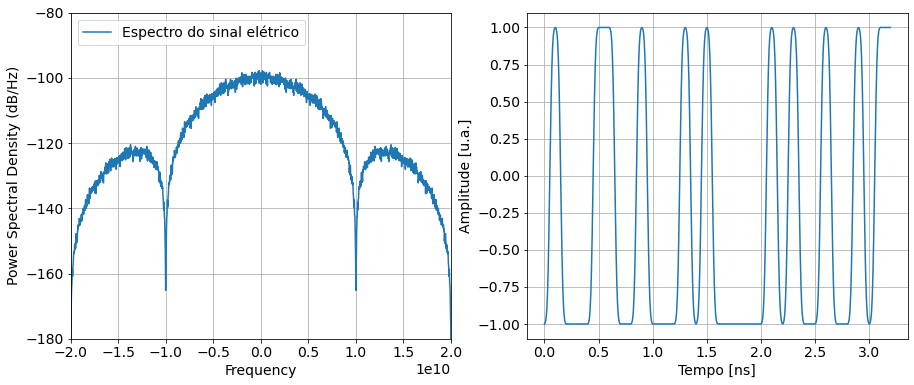

In [107]:
# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], sigTx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

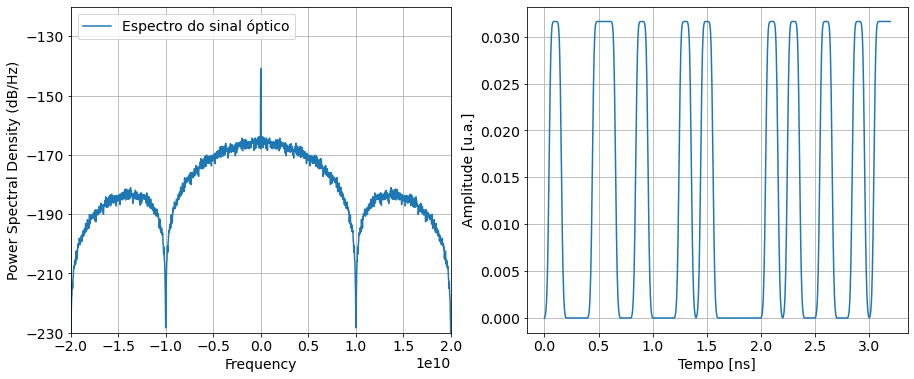

In [108]:
# modulação óptica
Ai     = np.sqrt(Pi)
sigTxo = mzm(Ai, Vπ, sigTx, Vb)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-230,-120);
axs[0].psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], np.abs(sigTxo[idX]))
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

In [112]:
# transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

# Fibra óptica
H  = np.exp(1j*0.5*beta2*z*(2*np.pi*freq)**2) # Função de transferência do canal
sigRxoFFT = H * sigTxoFFT
sigRxoPx  = np.abs(sigRxoFFT)**2
sigRxo = np.fft.ifft(sigRxoFFT)*NFFT

Potência do sinal (em dBm) = -3.06 dBm


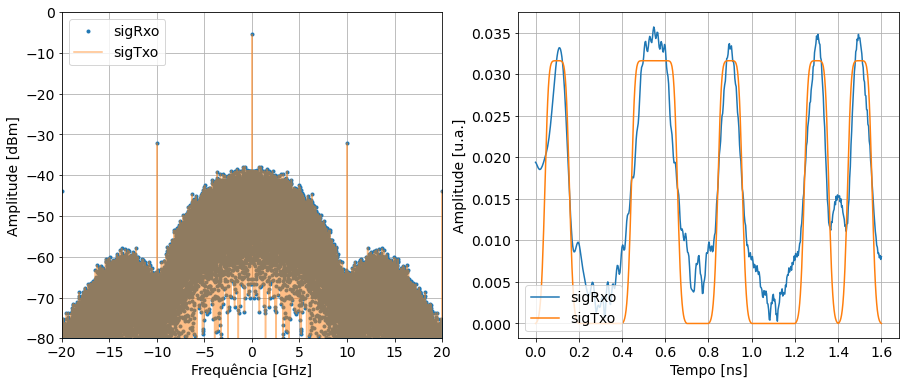

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel('Amplitude [dBm]')
axs[0].set_xlabel('Frequência [GHz]')
axs[0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0].set_ylim(-80,0)
axs[0].grid(True)
axs[0].legend(loc = 'upper left')

axs[1].plot(t[0:513], abs(sigRxo[0:513]), label = 'sigRxo')
axs[1].plot(t[0:513], abs(sigTxo[0:513]), label = 'sigTxo')
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
axs[1].legend(loc = 'lower left')

print('Potência do sinal (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))

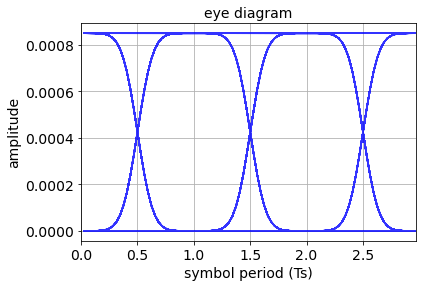

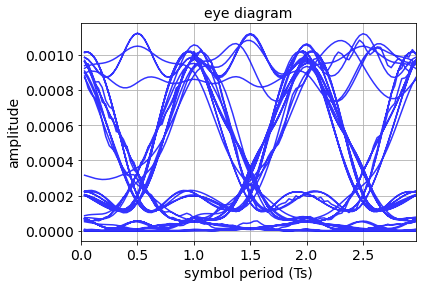

In [114]:
# Recepção do sinal óptico
Nsamples = 2**12

# fotocorrente livre de ruído
Ip   = Rd*np.abs(sigTxo)**2
I_Rx = Rd*np.abs(sigRxo)**2

# diagrama de olho
eyediagram(Ip,  Nsamples, SpS)
eyediagram(I_Rx, Nsamples, SpS)